In [1]:
#Install these
import matplotlib.pyplot as plt
import IPython.display as ipd #Do I really need this???
import librosa
import librosa.display #Comes with librosa
import pandas as pd
import sounddevice as sd
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

#No need to install these
import os

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()

#DO NOT INSTALL THIS, let librosa do it
import numpy as np

#Don't remember
from scipy.io import wavfile as wav

#This allows .ipynb to show plot or something, should type it
%matplotlib inline

Data Preprocessing

In [2]:
#Specifying paths
dataPath = 'Audio/'
metaData = pd.read_csv('metadata.csv')

In [3]:
#Function to extract Mel-Frequency Cepstral Coefficient
def featuresExtractor(file):
    audio, sRate = librosa.load(file, res_type='kaiser_fast') #Load file prioritising speed, cuz we're doin' machine learning, not music
    mfcc = librosa.feature.mfcc(y=audio, sr=sRate, n_mfcc=40)
    mfccScaled = np.mean(mfcc.T, axis=0) #Find the mean from the transposed array

    return mfccScaled

In [4]:
#This is used to create an array with thinggy inside of it, takes quite a while to load
features = []

for index, row in tqdm(metaData.iterrows()):
    fileName = os.path.join(os.path.abspath(dataPath), str(row["Note"]) + '/', str(row["Name"]))
    labels = row["Note"]
    data = featuresExtractor(fileName)
    features.append([data, labels])

1760it [01:14, 23.53it/s]


In [6]:
df = pd.DataFrame(features, columns=['features', 'class'])
df.head

<bound method NDFrame.head of                                                features class
0     [-618.94244, 160.39342, 80.086685, 43.61678, 1...    Am
1     [-652.1719, 152.57881, 55.81178, 39.47468, 5.2...    Am
2     [-232.73901, 144.85373, -17.409685, 36.19547, ...    Am
3     [-245.83714, 154.66487, -12.436771, 36.953526,...    Am
4     [-243.50058, 135.22137, -12.819307, 36.791035,...    Am
...                                                 ...   ...
1755  [-584.32574, 172.95914, 53.141903, 46.334255, ...     G
1756  [-625.7727, 162.65997, 53.851185, 44.557674, 2...     G
1757  [-256.16782, 143.86983, -17.850994, 37.48406, ...     G
1758  [-259.35522, 138.84924, -16.882029, 36.305145,...     G
1759  [-240.57108, 139.67511, -22.976198, 35.051037,...     G

[1760 rows x 2 columns]>

In [113]:
#Split data to list (still don't know why)
X = np.array(df['features'].tolist())
y = np.array(df['class'].tolist())

In [114]:
y

array(['Am', 'Am', 'Am', ..., 'G', 'G', 'G'], dtype='<U4')

In [112]:
#Change classes to categorical, do not run twice
y = to_categorical(labelEncoder.fit_transform(y))

In [9]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Training

In [10]:
#Split testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [11]:
#Number of classes
numLabels = y.shape[1]
numLabels

8

ANN

In [74]:
#Create neural network's layers
ANNmodel = Sequential()

#Input layer
ANNmodel.add(Dense(1024, input_shape=(40,)))
ANNmodel.add(Activation('relu'))
ANNmodel.add(BatchNormalization())
ANNmodel.add(Dropout(0.3))

#Second layer
ANNmodel.add(Dense(512))
ANNmodel.add(Activation('relu'))
ANNmodel.add(BatchNormalization())
ANNmodel.add(Dropout(0.3))

#Third layer
ANNmodel.add(Dense(256))
ANNmodel.add(Activation('relu'))
ANNmodel.add(BatchNormalization())
ANNmodel.add(Dropout(0.3))

#Output layer
ANNmodel.add(Dense(numLabels, activation = 'softmax'))

In [75]:
ANNmodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              41984     
                                                                 
 activation_9 (Activation)   (None, 1024)              0         
                                                                 
 batch_normalization_9 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 activation_10 (Activation)  (None, 512)               0         
                                                      

In [76]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = 1e-5, beta_1 = 0.97)
ANNmodel.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer = 'adam')

In [77]:
#Actually Trainning
numEpochs = 300
batchSize = 128

ann = ANNmodel.fit(X_train, y_train, batch_size=batchSize, epochs=numEpochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/300
13/13 [==============================] - 1s 22ms/step - loss: 1.5634 - categorical_accuracy: 0.5246 - val_loss: 3.4770 - val_categorical_accuracy: 0.3295
Epoch 2/300
13/13 [==============================] - 0s 12ms/step - loss: 0.6526 - categorical_accuracy: 0.7860 - val_loss: 3.8955 - val_categorical_accuracy: 0.3466
Epoch 3/300
13/13 [==============================] - 0s 12ms/step - loss: 0.4369 - categorical_accuracy: 0.8561 - val_loss: 1.3716 - val_categorical_accuracy: 0.5909
Epoch 4/300
13/13 [==============================] - 0s 12ms/step - loss: 0.3459 - categorical_accuracy: 0.8908 - val_loss: 0.5115 - val_categorical_accuracy: 0.8466
Epoch 5/300
13/13 [==============================] - 0s 12ms/step - loss: 0.2800 - categorical_accuracy: 0.9034 - val_loss: 0.5416 - val_categorical_accuracy: 0.8409
Epoch 6/300
13/13 [==============================] - 0s 11ms/step - loss: 0.2705 - categorical_accuracy: 0.9122 - val_loss: 0.1860 - val_categorical_accuracy: 0.9489
Epoc

In [116]:
testAccuracy = ANNmodel.evaluate(X_test, y_test, verbose=0)
print(testAccuracy[1])

0.9715909361839294


Accuracy Analysis

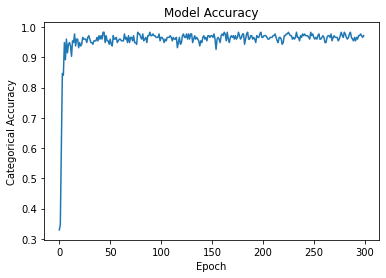

In [79]:
plt.plot(ann.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.show()

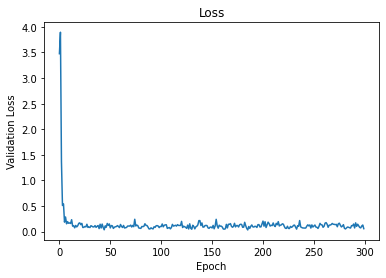

In [80]:
plt.plot(ann.history['val_loss'])
plt.title('Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.show()

Saving

In [109]:
#I use manual saving because I play around with this a lot and not everything needs to be saved
ANNmodel.save('./saved_models/ANN_Classification.h5')

Testing

In [103]:
fileName = 'Test/chord/Em.wav'
audio, sampleRate = librosa.load(fileName, res_type='kaiser_fast')

mfcc = librosa.feature.mfcc(y=audio, sr=sampleRate, n_mfcc=40)
mfccScaled = np.mean(mfcc.T, axis=0)
mfccScaled = mfccScaled.reshape(1, -1)

predictedLabel = np.argmax(ANNmodel.predict(mfccScaled), axis=-1)
predictedClass = labelEncoder.inverse_transform(predictedLabel)

confidenceLevel = np.max(ANNmodel.predict(mfccScaled))

print(predictedClass[0], '{0:.2f} %'.format(confidenceLevel * 100))

Em 62.40 %


In [101]:
RATE = 44100
seconds = 3

recording = sd.rec(int(seconds * RATE), samplerate=RATE, channels=1)
sd.wait()
mfcc = librosa.feature.mfcc(y=recording.ravel(), sr=RATE, n_mfcc=40)
mfccScaled = np.mean(mfcc.T, axis=0)
mfccScaled = mfccScaled.reshape(1, -1)

predictedLabel = np.argmax(ANNmodel.predict(mfccScaled), axis=-1)
predictedClass = labelEncoder.inverse_transform(predictedLabel)

confidenceLevel = np.max(ANNmodel.predict(mfccScaled))

print(predictedClass[0], '{0:.2f} %'.format(confidenceLevel * 100))


Bdim 36.82 %
